# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-03-22 09:17:52.194382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 09:17:59.570957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-22 09:17:59.571081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object f

Num GPUs Available:  0


In [2]:
#df = pd.read_csv(r"C:\Users\John\Desktop\Formation\6-Classifiez automatiquement des biens de consommation\1-Projet_6\OC-DS-P6-Classifiez_automatiquement_biens_consommation\df.csv")
df = pd.read_csv('df.csv')

In [3]:
import os
import random
import shutil

# Chemin vers le dossier contenant toutes les images
#data_dir = r"C:\Users\John\Desktop\Formation\6-Classifiez automatiquement des biens de consommation\1-Projet_6\OC-DS-P6-Classifiez_automatiquement_biens_consommation\Images"
data_dir = 'Images/'

# Proportion des images à utiliser pour l'ensemble de test
test_ratio = 0.2

# Créer les dossiers pour l'ensemble de formation et l'ensemble de test
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Parcourir chaque fichier d'image dans le dossier
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg"):
        # Déterminer aléatoirement si l'image doit être dans l'ensemble de test ou d'apprentissage
        if random.uniform(0, 1) < test_ratio:
            # Déplacer l'image dans le dossier de l'ensemble de test
            shutil.move(os.path.join(data_dir, filename), os.path.join(test_dir, filename))
        else:
            # Déplacer l'image dans le dossier de l'ensemble d'apprentissage
            shutil.move(os.path.join(data_dir, filename), os.path.join(train_dir, filename))

In [4]:
from sklearn import preprocessing

path = train_dir
path_test = test_dir

#
list_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']
label_no_name = "no_name "

def photo_class(photo) :
    for label in list_labels :
        print('photo : ',str(photo)[-36:])
        img = str(photo)[-36:]
        if label in df.loc[(df['image'].isin([img]) == True), 'class_'] : #photo[24:] : 
            return label
    return label_no_name
    
data_path = glob(path+'*/*.jp*')
data_test_path = glob(path_test+'*/*.jp*')

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["label_name"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

#data = data_fct(data_path)
#data_test = data_fct(data_test_path)

# Filtre train et test
f_tr = os.listdir(train_dir)
f_te = os.listdir(test_dir)

# Appliquer le filtre à df
data = df.loc[df['image'].isin(f_tr),['image','class_']].reset_index(drop=True)
data_test = df.loc[df['image'].isin(f_te),['image','class_']].reset_index(drop=True)

# Renommer les colonnes
data.rename(columns = {'class_':'label_name', 'image':'image_path'}, inplace = True)
data_test.rename(columns = {'class_':'label_name', 'image':'image_path'}, inplace = True)

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])
# data.head(5)
data_test.head(5)

,image_path,label_name,label
0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Watches,6
1,62c35de4df27437d3597963fac55a8b6.jpg,Watches,6
2,7c4fec2331da8d40f2cb146eb198cb57.jpg,Watches,6
3,ee8d9ff65e0fe4278afce7c933d30941.jpg,Watches,6
4,b85f8843bb1c297dd5712f0bd287006d.jpg,Home Furnishing,4


In [5]:
data.groupby("label").count()

,image_path,label_name
label,,
0,119,119
1,111,111
2,121,121
3,123,123
4,128,128
5,115,115
6,116,116


# classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [18]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [20]:
%%time
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        try :
            img = (load_img(train_dir + '/' +
            data['image_path'][image_num],
            target_size=(224, 224)))
        except :
            img = (load_img(test_dir + '/' +
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [21]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(624, 224, 224, 3)

In [23]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [24]:
# Recherche du plus grand diviseur
num = X_train.shape[0]
for i in range(2, num):
    if i < 80:
        if num % i == 0:
            diviseur = i
    else :
        continue

print("Le plus grand diviseur < 80 de", num, "est", diviseur)

Le plus grand diviseur < 80 de 624 est 78


In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(624, 224, 224, 3) (624, 7) (215, 224, 224, 3) (215, 7) (209, 224, 224, 3) (209, 7)


In [26]:
# Entraîner sur les données d'entraînement (X_train, y_train) epochs=5 au lieu de 50
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=2, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 5.9917 - accuracy: 0.4487
Epoch 1: val_loss improved from inf to 1.29794, saving model to ./model1_best_weights.h5
10/10 [==============================] - 59s 6s/step - loss: 5.9917 - accuracy: 0.4487 - val_loss: 1.2979 - val_accuracy: 0.7512
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 2.0162 - accuracy: 0.6651
Epoch 2: val_loss improved from 1.29794 to 1.26578, saving model to ./model1_best_weights.h5
10/10 [==============================] - 58s 6s/step - loss: 2.0162 - accuracy: 0.6651 - val_loss: 1.2658 - val_accuracy: 0.7656


In [27]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 44s 2s/step - loss: 0.7277 - accuracy: 0.8654
Training Accuracy: 0.8654

7/7 [==============================] - 15s 2s/step - loss: 1.2658 - accuracy: 0.7656
Validation Accuracy:  0.7656


In [28]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7656
Test Accuracy       :  0.7767


In [29]:
pip install plot-keras-history

Note: you may need to restart the kernel to use updated packages.


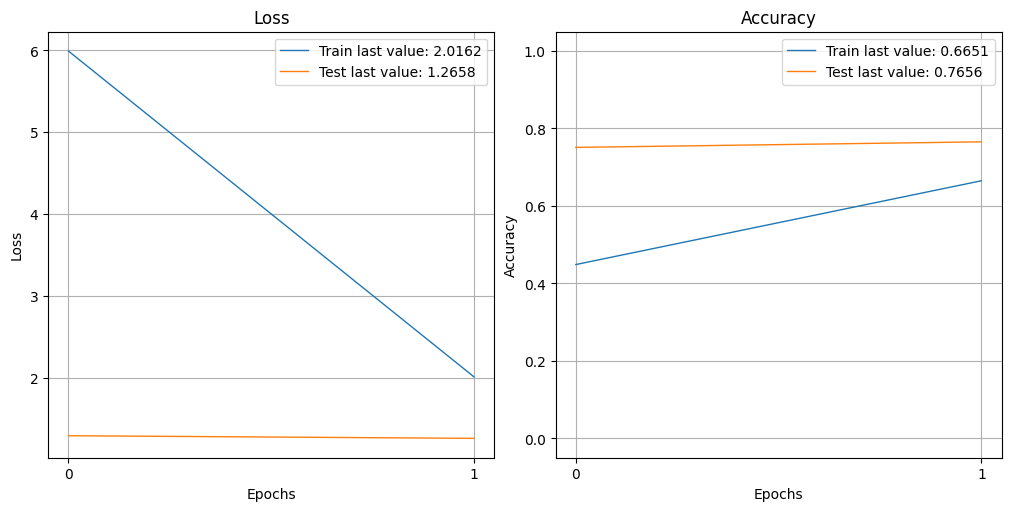

In [30]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [31]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 15s 2s/step
[5 4 2 5 2 6 6 2 3 6 0 4 3 5 2 0 6 0 4 3 3 6 3 3 6 2 3 6 2 0 0 2 5 0 0 6 5
 3 6 4 4 5 1 4 5 1 2 3 2 4 4 1 6 6 2 5 2 3 6 4 0 0 3 3 5 2 0 1 6 4 4 2 4 0
 5 0 2 5 4 2 1 1 3 5 4 3 5 4 6 3 3 1 3 4 5 1 6 0 1 4 0 3 5 2 2 6 1 4 5 5 3
 2 6 3 6 1 4 5 2 1 6 6 1 1 2 3 5 4 5 3 4 3 3 5 1 0 4 4 0 5 4 1 6 1 1 4 1 2
 4 0 2 4 1 5 2 4 1 0 2 4 0 0 2 6 4 2 4 3 0 0 6 3 0 4 6 5 0 2 3 1 6 0 6 1 5
 0 5 2 0 1 6 1 2 1 3 6 3 6 5 0 0 1 1 5 2 3 5 0 3]

[5 4 2 5 2 6 6 6 6 6 0 5 3 5 3 4 6 4 4 0 3 6 3 3 6 2 3 6 2 0 0 2 5 1 4 6 5
 3 6 4 4 5 1 4 5 1 2 5 2 4 4 1 6 6 2 5 5 3 6 4 5 1 3 6 5 2 0 3 6 4 4 2 4 5
 5 0 2 5 4 2 1 5 3 5 4 3 5 3 6 3 6 1 3 4 5 1 6 3 1 4 3 6 5 3 2 6 1 4 5 5 5
 2 6 3 6 1 4 5 2 4 6 6 1 1 2 5 5 4 5 3 4 3 5 5 2 0 2 4 6 5 4 1 6 1 1 4 1 5
 4 3 2 4 2 5 2 4 2 2 5 4 4 0 2 6 4 3 4 3 0 0 6 2 4 4 6 5 4 2 3 1 6 0 6 1 5
 6 5 2 0 1 6 1 2 2 4 6 3 6 5 1 4 1 1 2 2 3 5 4 4]


In [32]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[11  3  1  3  8  2  2]
 [ 0 21  4  1  1  1  0]
 [ 0  0 23  3  0  3  1]
 [ 1  0  1 19  2  4  4]
 [ 0  0  1  1 29  1  0]
 [ 0  0  1  0  0 28  0]
 [ 0  0  0  0  0  0 29]]


In [33]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)

conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[11  3  1  3  8  2  2]
 [ 0 21  4  1  1  1  0]
 [ 0  0 23  3  0  3  1]
 [ 1  0  1 19  2  4  4]
 [ 0  0  1  1 29  1  0]
 [ 0  0  1  0  0 28  0]
 [ 0  0  0  0  0  0 29]]

              precision    recall  f1-score   support

           0       0.92      0.37      0.52        30
           1       0.88      0.75      0.81        28
           2       0.74      0.77      0.75        30
           3       0.70      0.61      0.66        31
           4       0.72      0.91      0.81        32
           5       0.72      0.97      0.82        29
           6       0.81      1.00      0.89        29

    accuracy                           0.77       209
   macro avg       0.78      0.77      0.75       209
weighted avg       0.78      0.77      0.75       209



<Axes: >

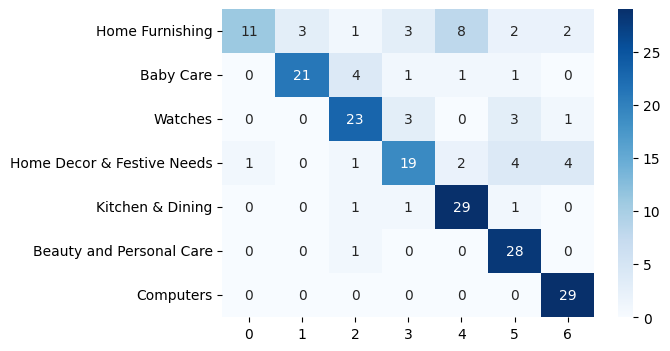

In [34]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "shine" contenant de la neige sont désormais bien affectées à "shine" et non pas "cloud"

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:
data

,image_path,label_name,label
0,c705a5735a94aeee547d1798e3e46ec4.jpg,Watches,6
1,7815fb39feb773db944c9f03bbdcbf64.jpg,Computers,2
2,1eda39f01d0a8a2e5ce4b32fc7da1027.jpg,Computers,2
3,11f06dffebf7edf9e15351834a190c2c.jpg,Baby Care,0
4,ce02ab514e4c623dcf7acd7182a7762d.jpg,Kitchen & Dining,5
...,...,...,...
828,d1e18b4a3aafb0040da2111c8b8ce2e5.jpg,Home Decor & Festive Needs,3
829,0d3e1dc0d38be59e9927e47f152e48aa.jpg,Kitchen & Dining,5
830,833a87b0af3b84fe246d2ebf271af177.jpg,Computers,2
831,97fba8a02361aa56eaa9fa51bc1d7661.jpg,Watches,6


In [38]:
%%time
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(train_dir +'/'+ image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
CPU times: user 4min 57s, sys: 2.64 s, total: 4min 59s
Wall time: 2min 50s


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(833, 4096)

In [39]:
batch_size = 32

def data_flow_fct_train(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory=train_dir+'/',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

def data_flow_fct_test(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory=test_dir+'/',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [40]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct_train(data, datagen_train, data_type='training')
val_flow = data_flow_fct_train(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct_test(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 625 validated image filenames belonging to 7 classes.
Found 208 validated image filenames belonging to 7 classes.
Found 215 validated image filenames belonging to 7 classes.


In [41]:
train_flow

In [42]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [44]:
train_flow

In [45]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=2, callbacks=callbacks_list, verbose=1)


Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 4.1846 - accuracy: 0.4368
Epoch 1: val_loss improved from inf to 1.32949, saving model to ./model2_best_weights.h5
20/20 [==============================] - 85s 4s/step - loss: 4.1846 - accuracy: 0.4368 - val_loss: 1.3295 - val_accuracy: 0.6971
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.6768
Epoch 2: val_loss did not improve from 1.32949
20/20 [==============================] - 84s 4s/step - loss: 1.6602 - accuracy: 0.6768 - val_loss: 1.3901 - val_accuracy: 0.7067


/anaconda/envs/jupyter_env/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [46]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 61s 3s/step - loss: 0.6576 - accuracy: 0.8080
Training Accuracy   : 0.8080

7/7 [==============================] - 21s 3s/step - loss: 1.2189 - accuracy: 0.7212
Validation Accuracy :  0.7212


In [47]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7308
Test Accuracy       :  0.7302


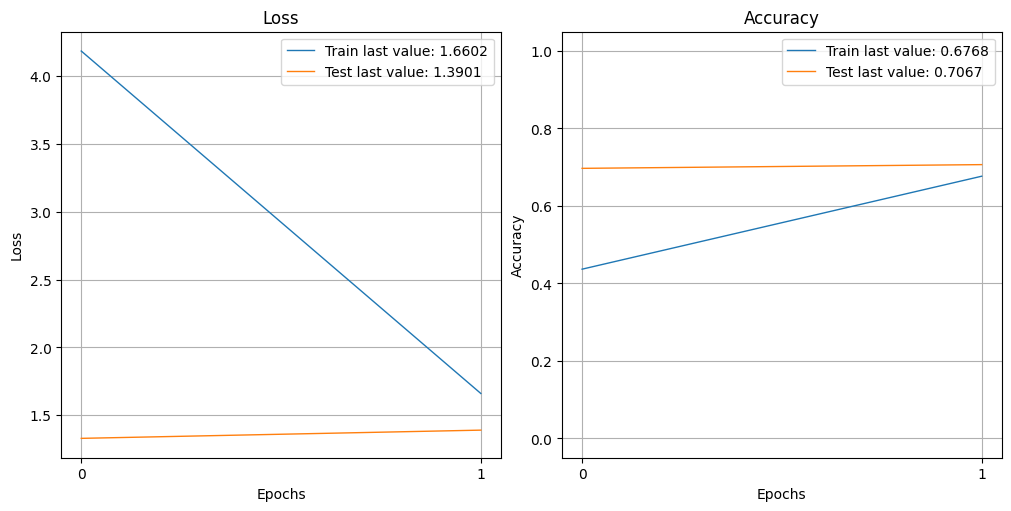

In [48]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [49]:
import os
import shutil

# Le chemin vers le dossier d'entraînement
train_dir = 'train-copy/'

# La table de correspondance entre le nom de l'image et son étiquette
data_train_dic = data.set_index('image_path')['label_name'].to_dict()

# Boucle à travers chaque image dans le dossier de formation
for filename in os.listdir(train_dir):
    # Si l'élément de la boucle est un fichier image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Trouver l'étiquette associée à l'image en utilisant la table de correspondance
        label_name = data_train_dic.get(filename)
        # Si l'étiquette existe dans la table de correspondance
        if label_name is not None:
            # Créer un nouveau dossier pour l'étiquette s'il n'existe pas déjà
            print(label_name)
            label_dir = os.path.join(train_dir, label_name)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
                print(label_dir)
            # Déplacer l'image dans le sous-dossier de l'étiquette
            src_path = os.path.join(train_dir, filename)
            dst_path = os.path.join(label_dir, filename)
            shutil.move(src_path, dst_path)

In [50]:
import os
import shutil

# Le chemin vers le dossier d'entraînement
test_dir = 'test-copy/'

# La table de correspondance entre le nom de l'image et son étiquette
data_test_dic = data_test.set_index('image_path')['label_name'].to_dict()

# Boucle à travers chaque image dans le dossier de formation
for filename in os.listdir(test_dir):
    # Si l'élément de la boucle est un fichier image
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Trouver l'étiquette associée à l'image en utilisant la table de correspondance
        label_name = data_test_dic.get(filename)
        # Si l'étiquette existe dans la table de correspondance
        if label_name is not None:
            # Créer un nouveau dossier pour l'étiquette s'il n'existe pas déjà
            print(label_name)
            label_dir = os.path.join(test_dir, label_name)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)
                print(label_dir)
            # Déplacer l'image dans le sous-dossier de l'étiquette
            src_path = os.path.join(test_dir, filename)
            dst_path = os.path.join(label_dir, filename)
            shutil.move(src_path, dst_path)

In [51]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical', #'inferred'
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [52]:
dataset_train = dataset_fct('train-copy', validation_split=0.25, data_type='training')
dataset_val = dataset_fct('train-copy', validation_split=0.25, data_type='validation')
dataset_test = dataset_fct('test-copy', validation_split=0, data_type=None)

Found 833 files belonging to 7 classes.
Using 625 files for training.
Found 833 files belonging to 7 classes.
Using 208 files for validation.
Found 215 files belonging to 7 classes.


In [53]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [55]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=2, callbacks=callbacks_list, verbose=1)


Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 5.7459 - accuracy: 0.4432
Epoch 1: val_loss improved from inf to 1.81743, saving model to ./model3_best_weights.h5
20/20 [==============================] - 68s 3s/step - loss: 5.7459 - accuracy: 0.4432 - val_loss: 1.8174 - val_accuracy: 0.7260
Epoch 2/2
20/20 [==============================] - ETA: 0s - loss: 2.5059 - accuracy: 0.6816
Epoch 2: val_loss improved from 1.81743 to 1.38832, saving model to ./model3_best_weights.h5
20/20 [==============================] - 67s 3s/step - loss: 2.5059 - accuracy: 0.6816 - val_loss: 1.3883 - val_accuracy: 0.7212


In [56]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 49s 2s/step - loss: 0.6208 - accuracy: 0.8576
Training Accuracy   : 0.8576

7/7 [==============================] - 18s 2s/step - loss: 1.3883 - accuracy: 0.7212
Validation Accuracy :  0.7212


In [57]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7212
Test Accuracy       :  0.7302


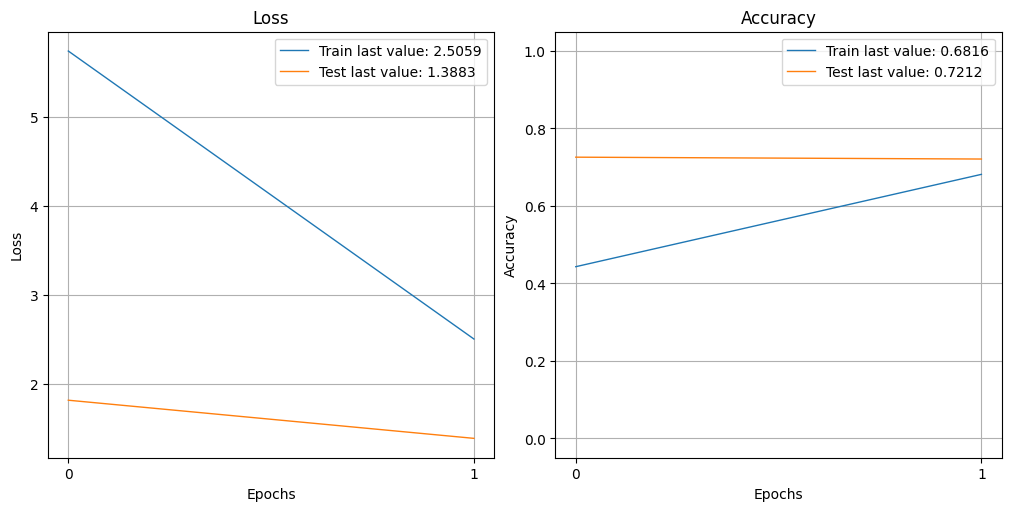

In [58]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [59]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [60]:
dataset_train = dataset_fct('train-copy', validation_split=0.25, data_type='training')
dataset_val = dataset_fct('train-copy', validation_split=0.25, data_type='validation')
dataset_test = dataset_fct('test-copy', validation_split=0, data_type=None)

Found 833 files belonging to 7 classes.
Using 625 files for training.
Found 833 files belonging to 7 classes.
Using 208 files for validation.
Found 215 files belonging to 7 classes.


In [61]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [62]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')#4
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [63]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [64]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [65]:
%%time
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8404 - accuracy: 0.2592
Epoch 1: val_loss improved from inf to 1.47617, saving model to ./model4_best_weights.h5
20/20 [==============================] - 80s 4s/step - loss: 1.8404 - accuracy: 0.2592 - val_loss: 1.4762 - val_accuracy: 0.6010
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4246 - accuracy: 0.5232
Epoch 2: val_loss improved from 1.47617 to 1.12815, saving model to ./model4_best_weights.h5
20/20 [==============================] - 68s 3s/step - loss: 1.4246 - accuracy: 0.5232 - val_loss: 1.1282 - val_accuracy: 0.6827
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.6144
Epoch 3: val_loss im

In [66]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 49s 2s/step - loss: 0.1874 - accuracy: 0.9392
Training Accuracy   : 0.9392

7/7 [==============================] - 18s 2s/step - loss: 0.5389 - accuracy: 0.7837
Validation Accuracy :  0.7837


In [67]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8221
Test Accuracy       :  0.8233


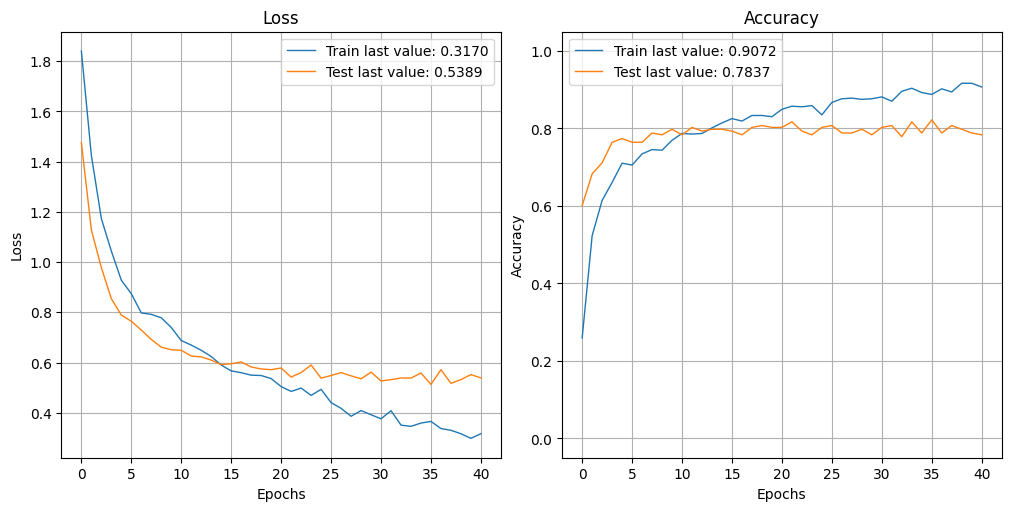

In [68]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

In [74]:
y_test_num = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model4.predict(X_test), axis=1)
y_test_num = np.argmax(y_test, axis=1)
print(y_test_num)
print()
print(y_test_pred)

7/7 [==============================] - 18s 2s/step
[6 6 6 6 4 3 5 2 5 1 2 1 5 5 5 4 0 0 0 3 3 1 1 0 5 0 0 1 1 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 3 5 3 3 5 3 3 3 3 5 3 5 5 3 5 3 5 3 5 3 3 5 3 0 0 0 3 3 1 1
 2 2 2 2 2 1 2 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 1 2 2 0 0 4 5 5 0 1 5 1 1 2 2
 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 1 1 4 3 0 1 0 0 2 0 0 4
 0 4 0 0 0 0 3 4 1 1 4 4 4 0 0 4 0 1 2 1 6 6 6 6 1 6 0 6 6 1 1 1 4 1 2 2 2
 2 2 2 2 2 2 4 4 3 6 4 3 4 4 4 1 4 3 4 4 3 0 0 5 5 1 3 2 4 0]

[6 6 6 6 3 1 5 2 5 5 2 1 5 1 3 4 4 0 4 3 3 4 4 0 5 0 0 2 3 5 5 5 5 5 5 5 5
 5 5 5 3 5 5 5 3 6 5 3 5 6 3 3 3 5 3 5 5 3 5 3 5 6 5 3 3 5 3 4 0 0 2 3 1 1
 2 2 2 2 2 1 2 1 1 1 2 3 2 1 1 1 1 1 1 1 1 1 3 2 2 0 0 4 5 5 0 3 5 1 1 2 2
 2 2 6 6 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 4 2 3 3 0 3 0 0 1 0 4 4
 3 4 0 3 0 0 3 4 1 2 4 4 4 0 2 4 0 0 1 1 6 1 6 6 1 6 0 6 6 1 1 1 4 1 2 2 2
 2 2 2 2 2 2 4 4 3 2 4 3 4 4 0 1 4 2 0 4 3 4 0 5 5 1 2 2 4 3]


In [77]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred)
print(conf_mat)
y_test_pred_transform = conf_mat_transform(y_test_num, y_test_pred)



[[21  0  1  3  5  0  0]
 [ 1 26  3  5  3  1  0]
 [ 0  3 26  0  0  0  0]
 [ 0  1  3 19  0  1  2]
 [ 2  0  0  2 18  0  0]
 [ 0  1  0  2  0 31  1]
 [ 1  1  1  0  0  0 31]]
Correspondance des clusters :  [0 1 2 3 4 5 6]


In [78]:
conf_mat = metrics.confusion_matrix(y_test_num, y_test_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_test_num, y_test_pred_transform))



[[21  0  1  3  5  0  0]
 [ 1 26  3  5  3  1  0]
 [ 0  3 26  0  0  0  0]
 [ 0  1  3 19  0  1  2]
 [ 2  0  0  2 18  0  0]
 [ 0  1  0  2  0 31  1]
 [ 1  1  1  0  0  0 31]]

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        30
           1       0.81      0.67      0.73        39
           2       0.76      0.90      0.83        29
           3       0.61      0.73      0.67        26
           4       0.69      0.82      0.75        22
           5       0.94      0.89      0.91        35
           6       0.91      0.91      0.91        34

    accuracy                           0.80       215
   macro avg       0.80      0.80      0.79       215
weighted avg       0.81      0.80      0.80       215



<Axes: >

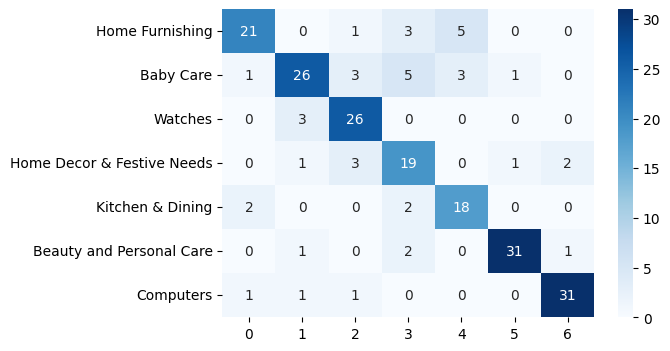

In [79]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")